# GetRetention 커스텀 모듈 사용 예시
- 데이터는 캐글의 'E-Commerce Data'를 활용했습니다.
- https://www.kaggle.com/carrie1/ecommerce-data

In [1]:
from my_modules import GetRetention as gr

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymysql
from datetime import timedelta

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

## 0. 불러오기 & 전처리

In [4]:
df = pd.read_csv('./data.csv', encoding='latin1')

In [5]:
print(df.shape)
df = df[df.CustomerID.notna()]
print(df.shape)

(541909, 8)
(406829, 8)


In [6]:
print(df.InvoiceDate[0])
df['date'] = df.InvoiceDate.str[:10]
df['date'] = df.date.str.split(' ').str[0]

temp = df.date.str.split('/',expand = True)
temp[0] = temp[0].apply(lambda x: '0' + x if len(x) == 1 else x)
temp[1] = temp[1].apply(lambda x: '0' + x if len(x) == 1 else x)

df['date'] = temp[2] + '-' + temp[0] + '-' + temp[1]
print(df.date[0])

12/1/2010 8:26
2010-12-01


In [7]:
df.rename({'CustomerID':'user_id'},axis =1,inplace=1)

## 1. 기능 예시

In [8]:
# 'get_cohort_table'은 첫구매와 코호트 기간이 포함된 테이블을 계산해줍니다.
cohort_table = gr.get_cohort_table(df[['user_id','date']])
cohort_table.head()

,user_id,date,first_date,cohort,first_month
0,17850.00,2010-12-01,2010-12-01,0,2010-12
1,17850.00,2010-12-01,2010-12-01,0,2010-12
2,17850.00,2010-12-01,2010-12-01,0,2010-12
3,17850.00,2010-12-01,2010-12-01,0,2010-12
4,17850.00,2010-12-01,2010-12-01,0,2010-12


In [9]:
# 'get_cohort'로 코호트를 계산할 수 있습니다.
gr.get_cohort(df[['user_id','date']])

cohort,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2010-12,100.00,38.19,33.44,38.71,35.97,39.66,37.97,35.44,35.44,39.45,37.34,50.00,27.43
2011-01,100.00,23.99,28.27,24.23,32.78,29.93,26.13,25.65,31.12,34.68,36.82,14.96,NaN
2011-02,100.00,24.74,19.21,27.89,26.84,24.74,25.53,28.16,25.79,31.32,9.21,NaN,NaN
2011-03,100.00,19.09,25.45,21.82,23.18,17.73,26.36,23.86,28.86,8.86,NaN,NaN,NaN
2011-04,100.00,22.74,22.07,21.07,20.74,23.75,23.08,26.09,8.36,NaN,NaN,NaN,NaN
2011-05,100.00,23.66,17.20,17.20,21.51,24.37,26.52,10.39,NaN,NaN,NaN,NaN,NaN
2011-06,100.00,20.85,18.72,27.23,24.68,33.62,10.21,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.00,20.94,20.42,23.04,27.23,11.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.00,25.15,25.15,25.15,13.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# 'get_retention'으로 리텐션을 계산할 수 있습니다.
gr.get_retention(df[['user_id', 'date']])

,0,1,2,3,4,5,6,7,8,9,10,11,12
retention,100.00,26.11,25.01,26.46,27.92,28.63,28.31,27.57,28.82,30.97,31.10,39.23,27.43


## 2. 분석 활용 예시
- 상위 10개 나라의 리텐션 m1 비교

In [12]:
# 주문 수 상위 10개 국가 리스트
df.Country.value_counts().head(10)

United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         1877
Portugal            1480
Australia           1259
Name: Country, dtype: int64

In [14]:
countries = df.Country.value_counts().head(10).index

In [82]:
c_retention = pd.DataFrame()
for country in countries:
    temp = df.loc[df.Country == country, ['user_id', 'date']]
    temp = gr.get_retention(temp)
    c_retention[country] = temp.iloc[0]
c_retention = c_retention.T
c_retention = c_retention.fillna(0)
c_retention = c_retention.sort_values(1, ascending = False)
c_retention

# 일부 구매기록이 부족한 나라에서 리텐션이 0으로 잡힙

,0,1,2,3,4,5,6,7,8,9,10,11,12
EIRE,100.00,66.67,66.67,100.00,66.67,100.00,66.67,100.00,66.67,66.67,66.67,66.67,33.33
Netherlands,100.00,66.67,66.67,75.00,60.00,66.67,50.00,66.67,50.00,75.00,66.67,50.00,50.00
Australia,100.00,62.50,37.50,37.50,25.00,25.00,37.50,25.00,75.00,25.00,37.50,33.33,0.00
Spain,100.00,58.33,31.25,46.67,0.00,33.33,26.32,37.50,50.00,25.00,41.67,75.00,25.00
Portugal,100.00,57.14,30.00,36.36,16.67,66.67,28.57,33.33,0.00,0.00,28.57,16.67,50.00
Belgium,100.00,53.33,35.00,58.82,42.86,47.37,47.37,22.22,46.15,33.33,33.33,50.00,50.00
Switzerland,100.00,45.45,50.00,42.86,100.00,100.00,80.00,42.86,50.00,100.00,66.67,0.00,0.00
Germany,100.00,39.08,39.77,35.71,38.36,44.07,37.74,39.62,35.85,39.53,51.28,46.15,33.33
France,100.00,37.33,32.89,36.21,28.12,38.33,40.35,35.71,37.50,44.74,40.62,50.00,20.00
United Kingdom,100.00,25.87,24.78,26.17,28.21,28.30,28.29,27.47,29.08,31.16,30.79,39.17,27.32


In [83]:
# 'get_cohort_table'함수를 통해 진짜 스페인에 cohort가 4인 주문이 없는지 확인
spain = df[df.Country == 'Spain']
spain_cohort_table = gr.get_cohort_table(spain[['user_id', 'date']])
(spain_cohort_table.cohort == 4).sum()

0

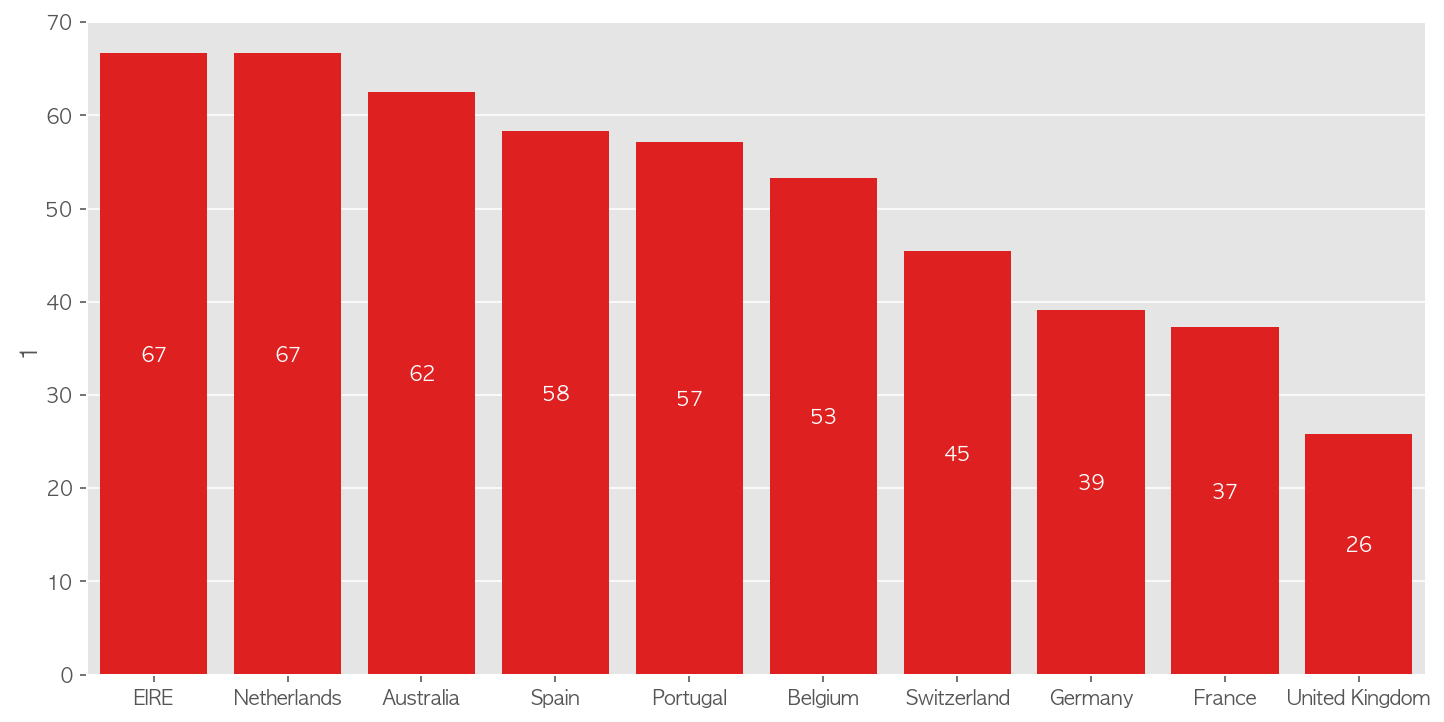

In [85]:
# get_retention으로 계산한 국가별 리텐션을 시각화
plt.figure(figsize = (12,6))

g = sns.barplot(x = c_retention.index, y = 1, data = c_retention, color = 'r')

for p in g.patches:
    g.annotate(round(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()/2-1),
        ha='center', va='center', xytext=(0, 9),
        textcoords='offset points', color = 'w')
# 아일랜드와 네덜란드의 m1 리텐션이 가장 좋은 것을 볼 수 있다
# 특히 아일랜드는 주문 수가 비슷한 독일이나 프랑스에 비해 m1리텐션이 약 2배 가량 좋기 때문에 전략적으로 중요한 국가가 될 수 있다.